In [1]:
import os
import shutil
import sys
threads_num = 2
os.environ["MKL_NUM_THREADS"] = f"{threads_num}" 
os.environ["NUMEXPR_NUM_THREADS"] = f"{threads_num}"
os.environ["OMP_NUM_THREADS"] = f"{threads_num}"
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
import numpy as np
import pandas as pd
import warnings

from utils import colors, sample_type_to_color, sample_type_to_label, export_legend, transform_model, merge_vdj_alleles, full_js_distance, draw_distances, get_distance_stats_test, draw_pvalues
hex_colors = ["#ffffff", "#31274a", "#8884ff", "#41c9c7", "#ffc914", "#5E3023", "#F7C59F", "#3F84E5", "#3423A6", "#ABD2FA"]
j_hex_colors = ["#824b82","#ab6ad9","#aa99ff","#2d7a79","#40c9ac","#41f0db","#945b22","#d9ab21","#ffef14"]
colors = [mpl.colors.hex2color(c) for c in hex_colors]
j_colors = [mpl.colors.hex2color(c) for c in j_hex_colors]

sns.set_style("ticks")

import genmodel

In [2]:
PROJECT_DIR = "../data/sensitivity/"
PGENS_DIR = "../data/greiff_cell_reports_naive_pgens/"
FIGURES_DIR = "../figures/figure_5/"

In [3]:

model = genmodel.GenModel(model_parms_file=os.path.join(PROJECT_DIR, "main_parms.txt"),
                          marginals_file=os.path.join(PROJECT_DIR, "main_marginals.txt"))

model_v_events = [(r.name, r.index) for r in model.events[0].realizations] 


v_name_to_index = {x.name : x.index for x in model.events[0].realizations}
j_name_to_index = {x.name : x.index for x in model.events[2].realizations}
j_name_to_index


v_name_to_index = {x.name : x.index for x in model.events[0].realizations}
j_name_to_index = {x.name : x.index for x in model.events[2].realizations}


v1_69_alleles = [x for x in v_name_to_index.keys() if x.split("*")[0] == "IGHV1-69"]
v4_34_alleles = [x for x in v_name_to_index.keys() if x.split("*")[0] == "IGHV4-34"]
v1_8_alleles = [x for x in v_name_to_index.keys() if x.split("*")[0] == "IGHV1-8"]


In [4]:
print([(ind, model.marginals[0]['v_choice'][v_name_to_index[ind]]) for ind in v1_69_alleles])
print(sum([model.marginals[0]['v_choice'][v_name_to_index[ind]] for ind in v1_69_alleles]))


print([(ind, model.marginals[0]['v_choice'][v_name_to_index[ind]]) for ind in v4_34_alleles])
print(sum([model.marginals[0]['v_choice'][v_name_to_index[ind]] for ind in v4_34_alleles]))

print([(ind, model.marginals[0]['v_choice'][v_name_to_index[ind]]) for ind in v1_8_alleles])
print(sum([model.marginals[0]['v_choice'][v_name_to_index[ind]] for ind in v1_8_alleles]))


[('IGHV1-69*08', 0.000216526), ('IGHV1-69*04', 0.0190746), ('IGHV1-69*06', 0.0373168), ('IGHV1-69*01', 0.00723666)]
0.06384458600000001
[('IGHV4-34*03', 0.00538025), ('IGHV4-34*01', 0.0238201)]
0.02920035
[('IGHV1-8*01', 0.00297712), ('IGHV1-8*02', 0.0018538)]
0.004830920000000001


In [5]:
input_marginals = os.path.join(PROJECT_DIR, "main_marginals.txt")
generic_output_marginals = os.path.join(PROJECT_DIR, "input_models/{}_marginals.txt")

In [6]:
def create_v_modified_marginals(gene, shift):
    output_marginals = generic_output_marginals.format(gene.replace("*", "_") + f"_shift_{shift}")
    with open(input_marginals) as inp:
        with open(output_marginals, 'w') as otp:
            for line_id, st in enumerate(inp):
                if line_id == 3:
                    array = np.array([float(s) for s in st[1:].split(',')])
                    array[v_name_to_index[gene]] *= shift
                    array /= array.sum()
                    modified_st = '%' + ','.join([str(x) if x != 0 else "0" for x in array]) + '\n'
                    otp.write(modified_st)
                else:
                    otp.write(st)
    input_parms = input_marginals[:-13] + "parms.txt"
    output_parms = output_marginals[:-13] + "parms.txt"
    shutil.copyfile(input_parms, output_parms)

In [7]:
v_genes = ['IGHV1-69*06', 'IGHV4-34*01', 'IGHV1-8*01']
for shift_size in [2.0, 5.0, 10.0]:
    for v_gene in v_genes:
        create_v_modified_marginals(v_gene, shift_size)

j_genes = ["IGHJ4*02", "IGHJ5*02", "IGHJ6*02"]


In [8]:
for v in v_genes:
    print()
    for j in j_genes:
        print(v, j, model.marginals[0]["j_choice"][v_name_to_index[v]][j_name_to_index[j]])



IGHV1-69*06 IGHJ4*02 0.17064
IGHV1-69*06 IGHJ5*02 0.136652
IGHV1-69*06 IGHJ6*02 0.107445

IGHV4-34*01 IGHJ4*02 0.457785
IGHV4-34*01 IGHJ5*02 0.0301213
IGHV4-34*01 IGHJ6*02 0.0795011

IGHV1-8*01 IGHJ4*02 0.306945
IGHV1-8*01 IGHJ5*02 0.109421
IGHV1-8*01 IGHJ6*02 0.243287


In [9]:
def create_j_modified_marginals(v_gene, j_gene, shift):
    output_marginals = generic_output_marginals.format(v_gene.replace("*", "_") + "_" + j_gene.replace("*", "_") + f"_shift_{shift}")
    with open(input_marginals) as inp:
        with open(output_marginals, 'w') as otp:
            current_section = ""
            write = False
            for line_id, st in enumerate(inp):
                if st[0] == '@':
                    current_section = st.strip()
                    otp.write(st)
                    continue
                if current_section != "@j_choice":
                    otp.write(st)
                    continue
                if write:
                    write = False
                    array = np.array([float(s) for s in st[1:].split(',')])
                    array[j_name_to_index[j_gene]] *= shift
                    array = (array / array.sum()).round(9)
                    print(v_gene, j_gene)
                    print(st)
                    modified_st = '%' + ','.join([str(x) if x != 0 else "0" for x in array]) + '\n'
                    otp.write(modified_st)
                    print(modified_st)
                    continue
                if st.strip() == f"#[v_choice,{v_name_to_index[v_gene]}]":
                    write = True
                    otp.write(st)
                    continue
                otp.write(st)
                
    input_parms = input_marginals[:-13] + "parms.txt"
    output_parms = output_marginals[:-13] + "parms.txt"
    shutil.copyfile(input_parms, output_parms)


In [10]:
for shift_size in [2.0, 5.0, 10.0]:
    for v_gene in v_genes:
        for j_gene in j_genes:
            create_j_modified_marginals(v_gene, j_gene, shift_size)

IGHV1-69*06 IGHJ4*02
%0.00124253,0,0,4.42269e-05,0,0,0,0.574716,0,0,0,0.17064,0,0,0.136652,0,0.107445,0.00926004,0

%0.001061411,0,0,3.778e-05,0,0,0,0.490941792,0,0,0,0.291532887,0,0,0.116732748,0,0.091783143,0.007910239,0

IGHV1-69*06 IGHJ5*02
%0.00124253,0,0,4.42269e-05,0,0,0,0.574716,0,0,0,0.17064,0,0,0.136652,0,0.107445,0.00926004,0

%0.001093149,0,0,3.891e-05,0,0,0,0.505621864,0,0,0,0.150125131,0,0,0.240446547,0,0.09452763,0.008146769,0

IGHV1-69*06 IGHJ6*02
%0.00124253,0,0,4.42269e-05,0,0,0,0.574716,0,0,0,0.17064,0,0,0.136652,0,0.107445,0.00926004,0

%0.001121979,0,0,3.9936e-05,0,0,0,0.518956793,0,0,0,0.15408443,0,0,0.123393961,0,0.194041275,0.008361627,0

IGHV4-34*01 IGHJ4*02
%0.00583966,0,0,0.00778596,0,0,0.00194655,0.411186,0,0,0,0.457785,0,0,0.0301213,0,0.0795011,0.00583454,0

%0.004005844,0,0,0.005340952,0,0,0.001335279,0.282062148,0,0,0,0.62805553,0,0,0.020662373,0,0.054535541,0.004002332,0

IGHV4-34*01 IGHJ5*02
%0.00583966,0,0,0.00778596,0,0,0.00194655,0.411186,0,0,0,0.457

In [11]:
default_model = genmodel.GenModel(model_parms_file=os.path.join(PROJECT_DIR, "main_parms.txt"),
                                  marginals_file=os.path.join(PROJECT_DIR, "main_marginals.txt"))


In [12]:
n_samples = 10
v_genes = ["IGHV1-69_06", "IGHV1-8_01", "IGHV4-34_01"]
shifts = [2.0, 5.0, 10.0]
sample_sizes = [1000, 3000, 10000, 30000]
v_reinferred_models = {(sample_size, gene, shift) : [] for sample_size in sample_sizes for gene in v_genes for shift  in shifts}
v_main_models = {}


In [13]:
for v_gene in v_genes:
    for shift in shifts:
        prefix = os.path.join(PROJECT_DIR, f"input_models/{v_gene}_shift_{shift}")
        main_model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                       marginals_file=prefix + "_marginals.txt")
        v_main_models[(v_gene, shift)] = main_model
        for n_sequences in sample_sizes:
            reinferred_models = []
            for replicate_id in range(n_samples):
                prefix = os.path.join(PROJECT_DIR, f"runs/{v_gene}_shift_{shift}_synthetic_replicate_{replicate_id}_{n_sequences}_run/main_inference/final")
                reinferred_model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                                     marginals_file=prefix + "_marginals.txt")
                reinferred_models.append(reinferred_model)
            v_reinferred_models[(n_sequences, v_gene, shift)] = reinferred_models
            


In [14]:
n_samples = 10
v_genes = ["IGHV1-69_06", "IGHV1-8_01", "IGHV4-34_01"]
j_genes = ["IGHJ4_02", "IGHJ5_02", "IGHJ6_02"]
shifts = [2.0, 5.0, 10.0]
sample_sizes = [1000, 3000, 10000, 30000]
j_reinferred_models = {(sample_size, v_gene, j_gene, shift) : [] for sample_size in sample_sizes for v_gene in v_genes for j_gene in j_genes for shift  in shifts}
j_main_models = {}


In [15]:
for v_gene in v_genes:
    for j_gene in j_genes:
        for shift in shifts:
            prefix = os.path.join(PROJECT_DIR, f"input_models/{v_gene}_{j_gene}_shift_{shift}")
            main_model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                           marginals_file=prefix + "_marginals.txt")
            j_main_models[(v_gene, j_gene, shift)] = main_model
            for n_sequences in sample_sizes:
                reinferred_models = []
                for replicate_id in range(n_samples):
                    prefix = os.path.join(PROJECT_DIR, f"runs/{v_gene}_{j_gene}_shift_{shift}_synthetic_replicate_{replicate_id}_{n_sequences}_run/main_inference/final")
                    reinferred_model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                                         marginals_file=prefix + "_marginals.txt")
                    reinferred_models.append(reinferred_model)
                j_reinferred_models[(n_sequences, v_gene, j_gene, shift)] = reinferred_models
            

In [16]:
def compute_deltas_v(sample_size, gene, shift):
    main_model = v_main_models[(gene, shift)]
    main_v_name_to_index = {x.name : x.index for x in main_model.events[0].realizations}
    gene_id = main_v_name_to_index[gene.replace("_", "*")]
    main_parameter = main_model.marginals[0]["v_choice"][gene_id]
    
    reinferred_models = v_reinferred_models[(sample_size, gene, shift)]
    deltas = []
    for model in reinferred_models:
        current_v_name_to_index = {x.name : x.index for x in model.events[0].realizations}
        current_gene_id = current_v_name_to_index[gene.replace("_", "*")]
        inferred_parameter = model.marginals[0]["v_choice"][current_gene_id]
        deltas.append(inferred_parameter - main_parameter)
    return np.array(deltas)

def compute_deltas_j(sample_size, v_gene, j_gene, shift):
    main_model = j_main_models[(v_gene, j_gene, shift)]
    main_v_name_to_index = {x.name : x.index for x in main_model.events[0].realizations}
    main_j_name_to_index = {x.name : x.index for x in main_model.events[2].realizations}
    v_gene_id = main_v_name_to_index[v_gene.replace("_", "*")]
    j_gene_id = main_j_name_to_index[j_gene.replace("_", "*")]
    main_parameter = main_model.marginals[0]["j_choice"][v_gene_id, j_gene_id]
    
    reinferred_models = j_reinferred_models[(sample_size, v_gene, j_gene, shift)]
    deltas = []
    for model in reinferred_models:
        current_v_name_to_index = {x.name : x.index for x in model.events[0].realizations}
        current_j_name_to_index = {x.name : x.index for x in model.events[2].realizations}
        if v_gene.replace("_", "*") not in current_v_name_to_index:
            inferred_parameter = 0
        else:
            current_v_gene_id = current_v_name_to_index[v_gene.replace("_", "*")]
            current_j_gene_id = current_j_name_to_index[j_gene.replace("_", "*")]
            inferred_parameter = model.marginals[0]["j_choice"][current_v_gene_id, current_j_gene_id]
        deltas.append(inferred_parameter - main_parameter)
    return np.array(deltas)


In [17]:
def compute_jsd_v(sample_size, gene, shift):
    gene_id = v_name_to_index[gene.replace("_", "*")]
    main_model = v_main_models[(gene, shift)]
    reinferred_models = v_reinferred_models[(sample_size, gene, shift)]
    distances = np.array([full_js_distance(merge_vdj_alleles(model), merge_vdj_alleles(main_model), exclude=[]) for model in reinferred_models])
    replicate_distances = [full_js_distance(merge_vdj_alleles(model_1), merge_vdj_alleles(model_2), exclude=[]) for i, model_1 in enumerate(reinferred_models) for model_2 in reinferred_models[i+1:]]
    return distances, replicate_distances

def compute_jsd_j(sample_size, v_gene, j_gene, shift):
    main_model = j_main_models[(v_gene, j_gene, shift)]
    reinferred_models = j_reinferred_models[(sample_size, v_gene, j_gene, shift)]
    distances = np.array([full_js_distance(merge_vdj_alleles(model), merge_vdj_alleles(main_model), exclude=[]) for model in reinferred_models])
    replicate_distances = [full_js_distance(merge_vdj_alleles(model_1), merge_vdj_alleles(model_2), exclude=[]) for i, model_1 in enumerate(reinferred_models) for model_2 in reinferred_models[i+1:]]
    return distances, replicate_distances


In [18]:
def draw_v_deltas(sample_size, output_filename, ylim):
    all_deltas = []
    all_shifts = []
    all_genes = []
    for v_gene in v_genes:
        for shift in shifts:
            current_deltas = compute_deltas_v(sample_size, v_gene, shift)
            current_shifts = [shift] * len(current_deltas)
            current_genes = [v_gene] * len(current_deltas)
            all_deltas.append(current_deltas)
            all_shifts.append(current_shifts)
            all_genes.append(current_genes)
    all_deltas = np.concatenate(all_deltas).astype(np.float64)
    all_shifts = np.concatenate(all_shifts).astype(np.float64)
    all_genes = np.concatenate(all_genes)
    x = "Implanted shift"
    y = "Value retrieval error"
    hue = "gene"
    palette = colors[2:]
    
    df = pd.DataFrame(np.array([all_shifts, all_deltas, all_genes]).T, columns =[x, y, hue])
    df[x] = df[x].astype(np.float64)
    df[y] = df[y].astype(np.float64)
    plt.figure(figsize=(8, 5))
    fontsize=25

    sns.boxplot(data=df, x=x, y=y, hue=hue, palette=palette, linewidth=1, fliersize=0)
    sns.swarmplot(data=df, x=x, y=y, hue=hue, color="black", dodge=True, size=3)
    plt.axhline(0.0, color="grey", linestyle="--", label="identical values")
    

    plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize)
    plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize)
    plt.xlabel(plt.gca().get_xlabel(), fontsize=fontsize)
    plt.ylabel(plt.gca().get_ylabel(), fontsize=fontsize)
    
    if ylim is not None:
        plt.ylim(ylim)

    plt.gca().get_legend().remove()

    plt.tight_layout()
    plt.savefig(output_filename, format="png")
    plt.show()


In [19]:
def draw_v_jsd(sample_size, output_filename, ylim):
    all_deltas = []
    all_shifts = []
    all_genes = []
    replicate_distances = []
    for v_gene in v_genes:
        for shift in shifts:
            current_deltas, current_replicate_distances = compute_jsd_v(sample_size, v_gene, shift)
            current_shifts = [shift] * len(current_deltas)
            current_genes = [v_gene] * len(current_deltas)
            all_deltas.append(current_deltas)
            all_shifts.append(current_shifts)
            all_genes.append(current_genes)
            replicate_distances.append(current_replicate_distances)
    all_deltas = np.concatenate(all_deltas).astype(np.float64)
    all_shifts = np.concatenate(all_shifts).astype(np.float64)
    all_genes = np.concatenate(all_genes)
    synthetic_replicates_distance = np.mean(np.concatenate(replicate_distances))
    all_deltas /= synthetic_replicates_distance
    x = "Implanted shift"
    y = "Normalized JSD"
    hue = "gene"
    palette = colors[2:]
    
    df = pd.DataFrame(np.array([all_shifts, all_deltas, all_genes]).T, columns =[x, y, hue])
    df[x] = df[x].astype(np.float64)
    df[y] = df[y].astype(np.float64)
    plt.figure(figsize=(8, 5))
    fontsize=25

    sns.boxplot(data=df, x=x, y=y, hue=hue, palette=palette, linewidth=1, fliersize=0)
    sns.swarmplot(data=df, x=x, y=y, hue=hue, color="black", dodge=True, size=3)
    
    plt.axhline(1.0, color="grey", linestyle="--", label="average synthetic replicates distance")
    

    plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize)
    plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize)
    plt.xlabel(plt.gca().get_xlabel(), fontsize=fontsize)
    plt.ylabel(plt.gca().get_ylabel(), fontsize=fontsize)

    if ylim is not None:
        plt.ylim(ylim)

    plt.gca().get_legend().remove()

    plt.tight_layout()
    plt.savefig(output_filename, format="png")
    plt.show()


In [20]:
def draw_j_deltas(sample_size, output_filename, ylim):
    all_deltas = []
    all_shifts = []
    all_genes = []
    for v_gene in v_genes:
        for j_gene in j_genes:
            for shift in shifts:
                current_deltas = compute_deltas_j(sample_size, v_gene, j_gene, shift)
                current_shifts = [shift] * len(current_deltas)
                current_genes = [f"{v_gene[3:-3]}_{j_gene[3:-3]}"] * len(current_deltas)
                all_deltas.append(current_deltas)
                all_shifts.append(current_shifts)
                all_genes.append(current_genes)
    all_deltas = np.concatenate(all_deltas).astype(np.float64)
    all_shifts = np.concatenate(all_shifts).astype(np.float64)
    all_genes = np.concatenate(all_genes)
    x = "Implanted shift"
    y = "Value retrieval error"
    hue = "gene"
    palette = colors[2:]
    
    df = pd.DataFrame(np.array([all_shifts, all_deltas, all_genes]).T, columns =[x, y, hue])
    df[x] = df[x].astype(np.float64)
    df[y] = df[y].astype(np.float64)
    plt.figure(figsize=(8, 5))
    fontsize=25

    sns.boxplot(data=df, x=x, y=y, hue=hue, palette=j_colors, linewidth=1, fliersize=0)
    sns.swarmplot(data=df, x=x, y=y, hue=hue, color="black", dodge=True, size=3)
    plt.axhline(0.0, color="grey", linestyle="--", label="identical values")
    

    plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize)
    plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize)
    plt.xlabel(plt.gca().get_xlabel(), fontsize=fontsize)
    plt.ylabel(plt.gca().get_ylabel(), fontsize=fontsize)

    if ylim is not None:
        plt.ylim(ylim)

    plt.gca().get_legend().remove()

    plt.tight_layout()
    plt.savefig(output_filename, format="png")
    plt.show()

In [21]:
def draw_j_jsd(sample_size, output_filename, ylim):
    all_deltas = []
    all_shifts = []
    all_genes = []
    replicate_distances = []
    for v_gene in v_genes:
        for j_gene in j_genes:
            for shift in shifts:
                current_deltas, current_replicate_distances = compute_jsd_j(sample_size, v_gene, j_gene, shift)
                current_shifts = [shift] * len(current_deltas)
                current_genes = [f"{v_gene[3:-3]}_{j_gene[3:-3]}"] * len(current_deltas)
                all_deltas.append(current_deltas)
                all_shifts.append(current_shifts)
                all_genes.append(current_genes)
                replicate_distances.append(current_replicate_distances)
    all_deltas = np.concatenate(all_deltas).astype(np.float64)
    all_shifts = np.concatenate(all_shifts).astype(np.float64)
    all_genes = np.concatenate(all_genes)
    synthetic_replicates_distance = np.mean(np.concatenate(replicate_distances))
    all_deltas /= synthetic_replicates_distance
    x = "Implanted shift"
    y = "Normalized JSD"
    hue = "gene"
    palette = colors[2:]
    
    df = pd.DataFrame(np.array([all_shifts, all_deltas, all_genes]).T, columns =[x, y, hue])
    df[x] = df[x].astype(np.float64)
    df[y] = df[y].astype(np.float64)
    plt.figure(figsize=(8, 5))
    fontsize=25

    sns.boxplot(data=df, x=x, y=y, hue=hue, palette=j_colors, linewidth=1, fliersize=0)
    sns.swarmplot(data=df, x=x, y=y, hue=hue, color="black", dodge=True, size=3)
    
    plt.axhline(1.0, color="grey", linestyle=":", label="average synthetic replicates distance")
    

    plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize)
    plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize)
    plt.xlabel(plt.gca().get_xlabel(), fontsize=fontsize)
    plt.ylabel(plt.gca().get_ylabel(), fontsize=fontsize)

    if ylim is not None:
        plt.ylim(ylim)

    plt.gca().get_legend().remove()

    plt.tight_layout()
    plt.savefig(output_filename, format="png")
    plt.show()


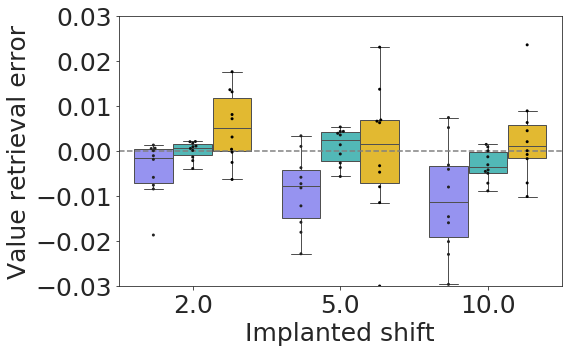

In [22]:
v_ylim = (-0.03, 0.03)
n_sequences = 1000
draw_v_deltas(n_sequences, os.path.join(FIGURES_DIR, f"v_deltas_{n_sequences}.png"), v_ylim)

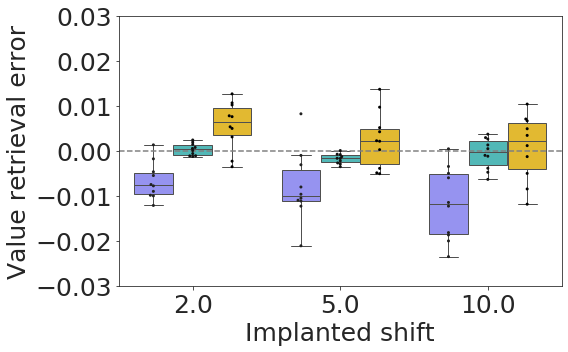

In [23]:
n_sequences = 3000
draw_v_deltas(n_sequences, os.path.join(FIGURES_DIR, f"v_deltas_{n_sequences}.png"), v_ylim)

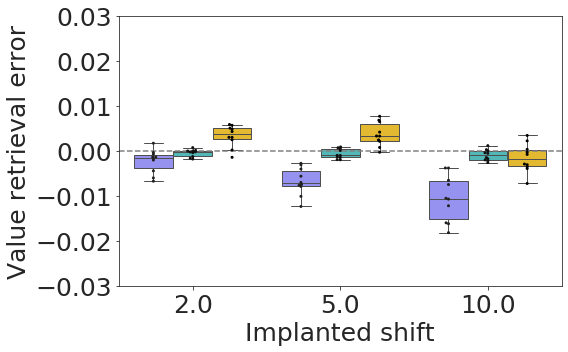

In [24]:
n_sequences = 10000
draw_v_deltas(n_sequences, os.path.join(FIGURES_DIR, f"v_deltas_{n_sequences}.png"), v_ylim)

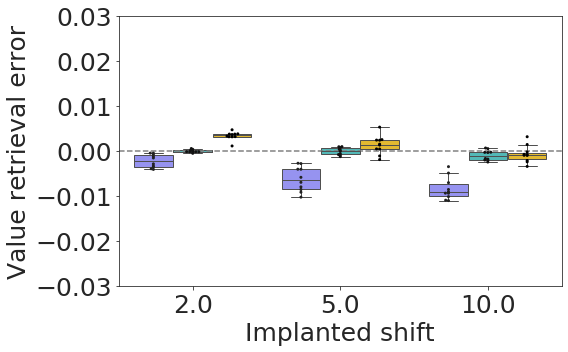

In [25]:
n_sequences = 30000
draw_v_deltas(n_sequences, os.path.join(FIGURES_DIR, f"v_deltas_{n_sequences}.png"), v_ylim)

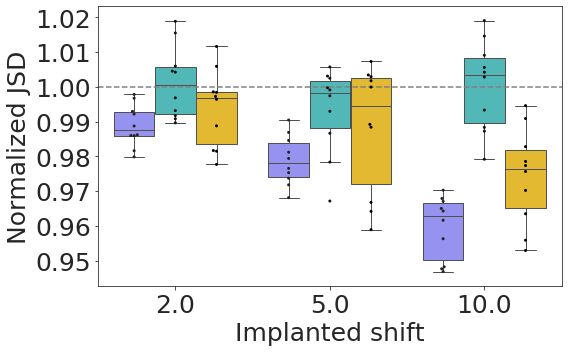

In [26]:
n_sequences = 1000
v_jsd_ylim = None#(0.945, 2.21)
draw_v_jsd(n_sequences, os.path.join(FIGURES_DIR, f"v_jsd_{n_sequences}.png"), ylim=v_jsd_ylim)

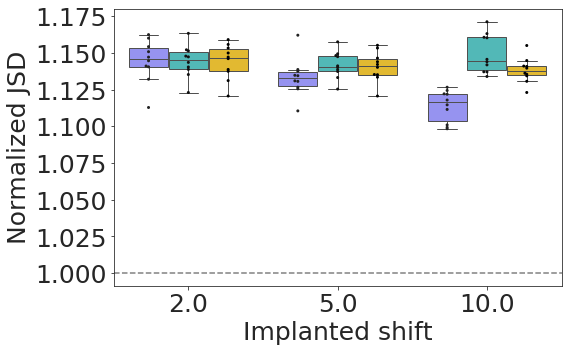

In [27]:
n_sequences = 3000
draw_v_jsd(n_sequences, os.path.join(FIGURES_DIR, f"v_jsd_{n_sequences}.png"), ylim=v_jsd_ylim)

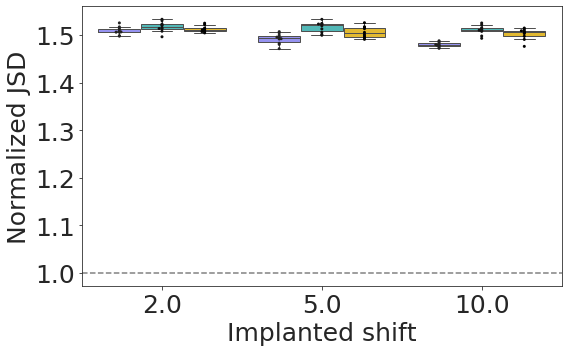

In [28]:
n_sequences = 10000
draw_v_jsd(n_sequences, os.path.join(FIGURES_DIR, f"v_jsd_{n_sequences}.png"), ylim=v_jsd_ylim)

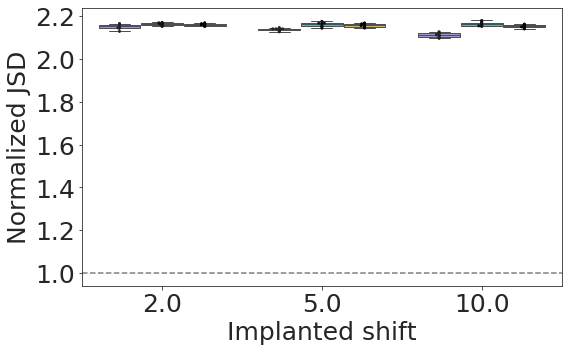

In [29]:
n_sequences = 30000
draw_v_jsd(n_sequences, os.path.join(FIGURES_DIR, f"v_jsd_{n_sequences}.png"), ylim=v_jsd_ylim)

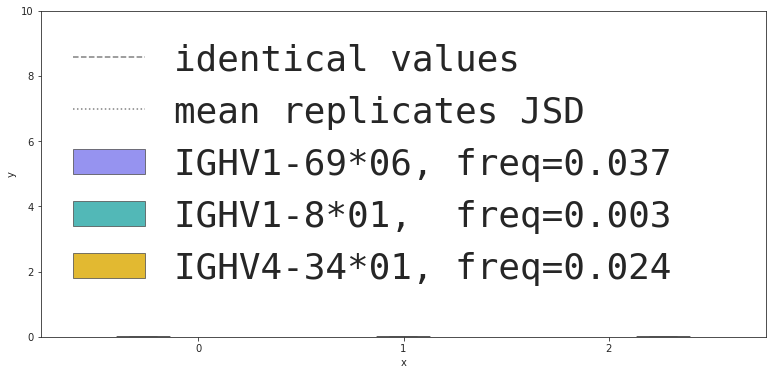

In [30]:
model = genmodel.GenModel(model_parms_file=os.path.join(PROJECT_DIR, "main_parms.txt"),
                          marginals_file=os.path.join(PROJECT_DIR, "main_marginals.txt"))
plt.figure(figsize=(13, 6))
fontsize=36

genes_labels = []
for i in range(len(v_genes)):
    gene = v_genes[i].replace('_', '*')
    gene_id = v_name_to_index[gene]
    genes_labels.append((gene + ",").ljust(13) + f"freq={round(model.marginals[0]['v_choice'][gene_id], 3)}")
df = pd.DataFrame(np.array([np.arange(len(v_genes)), np.repeat(0, len(v_genes)), genes_labels]).T, columns=["x", "y", "hue"])
df["x"] = df["x"].astype(np.int64)
df["y"] = df["y"].astype(np.int64)
sns.boxplot(data=df, x="x", y="y", hue="hue", palette=colors[2:])
plt.plot([0, 0], [0, 0], linestyle="--", color="grey", label="identical values")
plt.plot([0, 0], [0, 0], linestyle=":", color="grey", label="mean replicates JSD")
plt.ylim(0, 10)
leg = plt.legend(fontsize=fontsize, loc="upper left", prop={'family': 'monospace', "size": fontsize})
export_legend(leg, filename=os.path.join(FIGURES_DIR, "legend_v.png"))

plt.show()

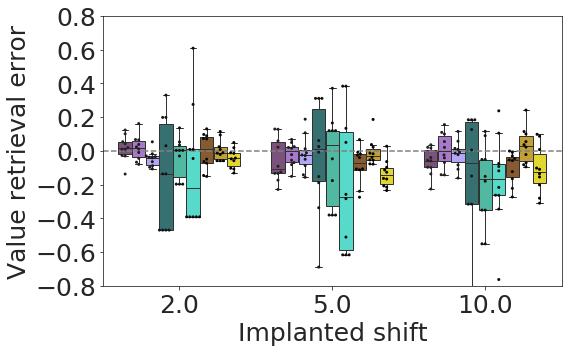

In [31]:
n_sequences = 1000
j_ylim = (-0.8, 0.8)
draw_j_deltas(n_sequences, os.path.join(FIGURES_DIR, f"j_deltas_{n_sequences}.png"), j_ylim)

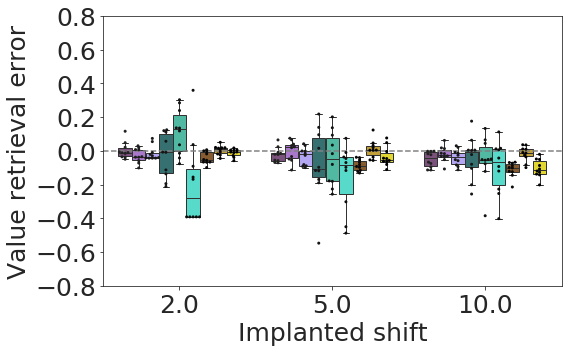

In [32]:
n_sequences = 3000
draw_j_deltas(n_sequences, os.path.join(FIGURES_DIR, f"j_deltas_{n_sequences}.png"), j_ylim)

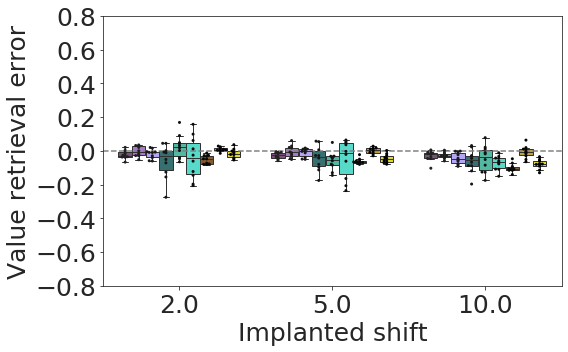

In [33]:
n_sequences = 10000
draw_j_deltas(n_sequences, os.path.join(FIGURES_DIR, f"j_deltas_{n_sequences}.png"), j_ylim)

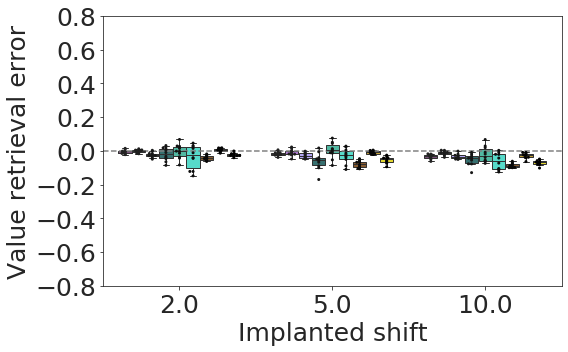

In [34]:
n_sequences = 30000
draw_j_deltas(n_sequences, os.path.join(FIGURES_DIR, f"j_deltas_{n_sequences}.png"), j_ylim)

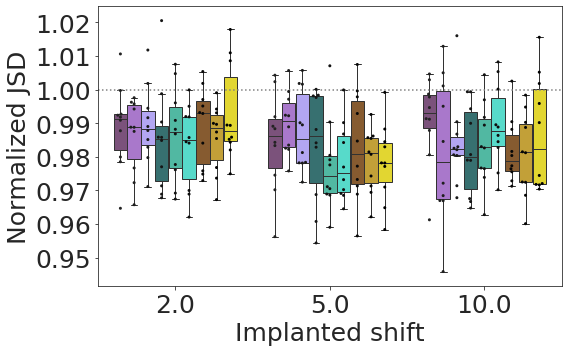

In [35]:
n_sequences = 1000
draw_j_jsd(n_sequences, os.path.join(FIGURES_DIR, f"j_jsd_{n_sequences}.png"), None)

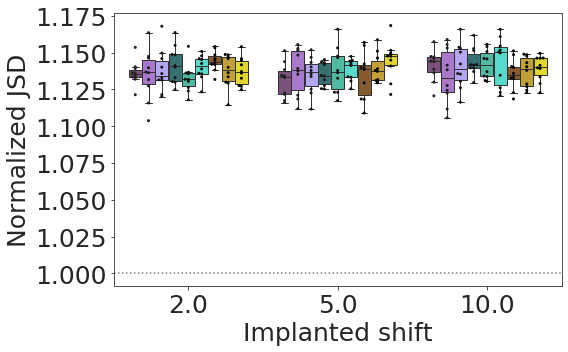

In [36]:
n_sequences = 3000
draw_j_jsd(n_sequences, os.path.join(FIGURES_DIR, f"j_jsd_{n_sequences}.png"), None)

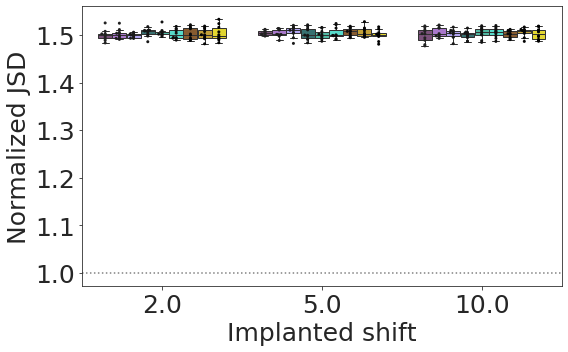

In [37]:
n_sequences = 10000
draw_j_jsd(n_sequences, os.path.join(FIGURES_DIR, f"j_jsd_{n_sequences}.png"), None)

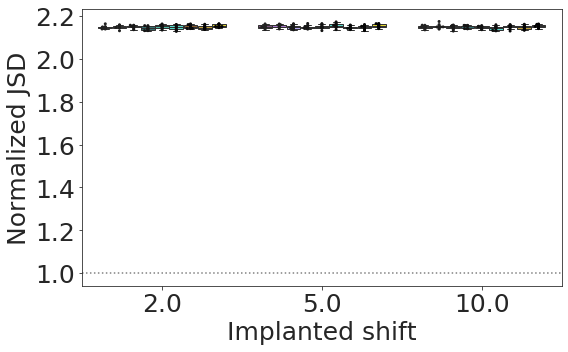

In [38]:
n_sequences = 30000
draw_j_jsd(n_sequences, os.path.join(FIGURES_DIR, f"j_jsd_{n_sequences}.png"), None)

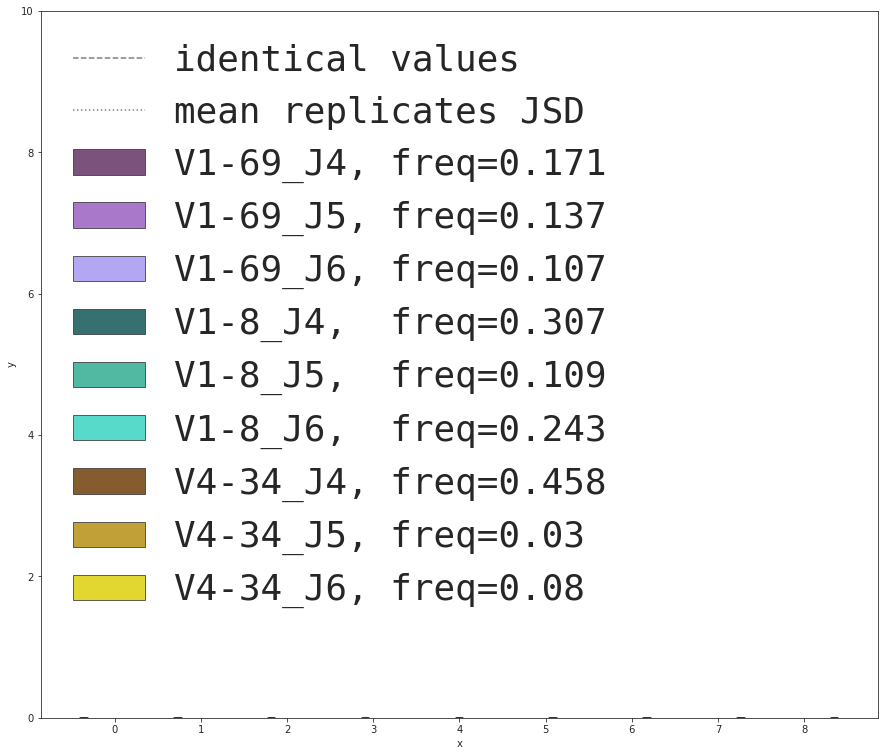

In [39]:
model = genmodel.GenModel(model_parms_file=os.path.join(PROJECT_DIR, "main_parms.txt"),
                          marginals_file=os.path.join(PROJECT_DIR, "main_marginals.txt"))
plt.figure(figsize=(15, 13))
fontsize=36

genes_labels = []
n = len(v_genes) * len(j_genes)
for i in range(len(v_genes)):
    for k in range(len(j_genes)):
        v_gene = v_genes[i].replace('_', '*')
        v_gene_id = v_name_to_index[v_gene]
        j_gene = j_genes[k].replace('_', '*')
        j_gene_id = j_name_to_index[j_gene]
        genes_labels.append((f"{v_gene[3:-3]}_{j_gene[3:-3]}"  + ",").ljust(10) + f"freq={round(model.marginals[0]['j_choice'][v_gene_id, j_gene_id], 3)}")
df = pd.DataFrame(np.array([np.arange(n), np.repeat(0, n), genes_labels]).T, columns=["x", "y", "hue"])
df["x"] = df["x"].astype(np.int64)
df["y"] = df["y"].astype(np.int64)
sns.boxplot(data=df, x="x", y="y", hue="hue", palette=j_colors)
plt.plot([0, 0], [0, 0], linestyle="--", color="grey", label="identical values")
plt.plot([0, 0], [0, 0], linestyle=":", color="grey", label="mean replicates JSD")
plt.ylim(0, 10)
leg = plt.legend(fontsize=fontsize, loc="upper left", prop={'family': 'monospace', "size": fontsize})
export_legend(leg, filename=os.path.join(FIGURES_DIR, "legend_j.png"))

plt.show()

In [40]:
model_name = "model_1"
pgen_model_1_df = pd.read_csv(os.path.join(PGENS_DIR, f"{model_name}_evaluate/inference_logs.txt"),
                         sep=';')
model_name = "model_1_data_replicate"
pgen_model_1_data_replicate_df = pd.read_csv(os.path.join(PGENS_DIR, f"{model_name}_evaluate/inference_logs.txt"),
                         sep=';')
model_name = "model_1_technical_replicate"
pgen_model_1_technical_replicate_df = pd.read_csv(os.path.join(PGENS_DIR, f"{model_name}_evaluate/inference_logs.txt"),
                         sep=';')
model_name = "model_2"
pgen_model_2_df = pd.read_csv(os.path.join(PGENS_DIR, f"{model_name}_evaluate/inference_logs.txt"),
                         sep=';')


In [41]:
pgen_model_1 = pgen_model_1_df.set_index("seq_index").seq_likelihood.sort_index()
pgen_model_1_data_replicate = pgen_model_1_data_replicate_df.set_index("seq_index").seq_likelihood.sort_index()
pgen_model_1_technical_replicate = pgen_model_1_technical_replicate_df.set_index("seq_index").seq_likelihood.sort_index()
pgen_model_2 = pgen_model_2_df.set_index("seq_index").seq_likelihood.sort_index()

In [42]:
eps = 1e-36


In [43]:
non_zero_indices = (pgen_model_1 > eps) &\
           (pgen_model_1_data_replicate > eps) &\
           (pgen_model_1_technical_replicate > eps) &\
           (pgen_model_2 > eps)
print(non_zero_indices.sum())
pgen_model_1 = pgen_model_1[non_zero_indices]
pgen_model_1_data_replicate = pgen_model_1_data_replicate[non_zero_indices]
pgen_model_1_technical_replicate = pgen_model_1_technical_replicate[non_zero_indices]
pgen_model_2 = pgen_model_2[non_zero_indices]


21330


In [44]:
def absolute_ratio(v1, v2, high_lim=1e4):
    return np.min([np.max([v1, v2], axis=0) / np.min([v1, v2], axis=0),
                   np.repeat(high_lim, repeats=v1.shape[0])], axis=0)



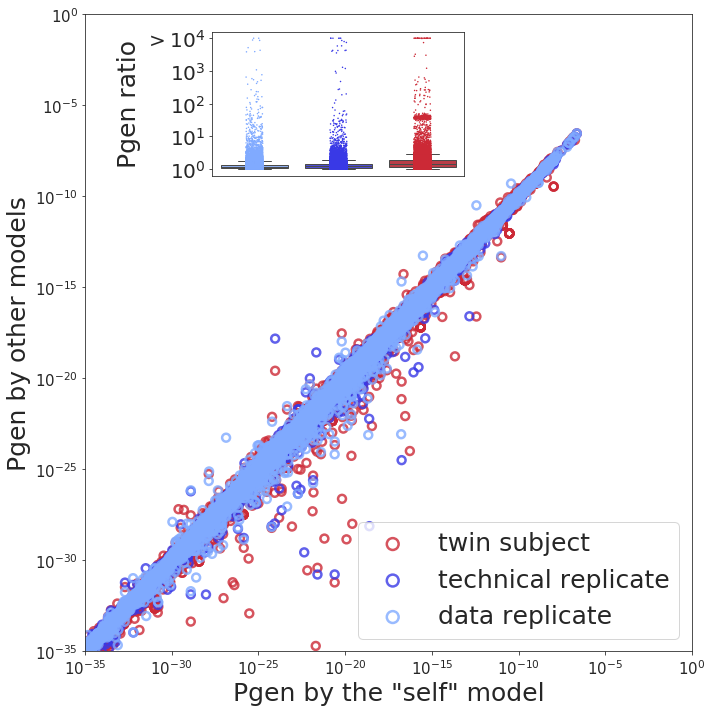

In [45]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(10, 10))

alpha=0.9
fontsize=25
alpha=0.8
linewidth=2.5
size = fontsize * 2.5

plt.scatter(x=pgen_model_1, y=pgen_model_2, alpha=alpha, s=size, linewidth=linewidth,
            color=sample_type_to_color["twins"],
            facecolors='none', marker='o',
            label=f"twin subject")
plt.scatter(x=pgen_model_1, y=pgen_model_1_technical_replicate, alpha=alpha, s=size, linewidth=linewidth,
            color=sample_type_to_color["technical"],
            facecolors='none', marker='o',
            label=f"technical replicate")
plt.scatter(x=pgen_model_1, y=pgen_model_1_data_replicate, alpha=alpha, s=size, linewidth=linewidth,
            color=sample_type_to_color["data"],
            facecolors='none', marker='o',
            label=f"data replicate")
low_lim = 1e-35
high_lim = 1.0
plt.xlim((low_lim, high_lim))
plt.ylim((low_lim, high_lim))
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Pgen by the \"self\" model", fontsize=fontsize)
plt.ylabel("Pgen by other models", fontsize=fontsize)
plt.legend(fontsize=fontsize, markerscale=1.5, loc="lower right")
plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize * 0.6)
plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize * 0.6)
plt.minorticks_off()



ax2 = fig.add_axes([0.3, 0.75, 0.35, 0.2])

data_replicate_ratios = absolute_ratio(pgen_model_1, pgen_model_1_data_replicate)
technical_replicate_ratios = absolute_ratio(pgen_model_1, pgen_model_1_technical_replicate)
twin_ratios = absolute_ratio(pgen_model_1, pgen_model_2)
all_ratios = np.concatenate([data_replicate_ratios, technical_replicate_ratios, twin_ratios])
hues = np.repeat(["data replicate", "technical replicate", "twin subject"], repeats=pgen_model_1.shape[0])
hue = "Sample type"
y = "Pgen ratio"
long_df = pd.DataFrame(np.array([all_ratios, hues]).T, columns=[y, hue])
long_df[y] = long_df[y].astype(np.float64)
sns.boxplot(data=long_df, x=hue, y=y,
            palette=[sample_type_to_color["data"],
                     sample_type_to_color["technical"],
                     sample_type_to_color["twins"]],
            fliersize=0,
            linewidth=1,
            ax=ax2)
sns.stripplot(data=long_df, x=hue, y=y,
            palette=[sample_type_to_color["data"],
                     sample_type_to_color["technical"],
                     sample_type_to_color["twins"]],
            size=1.5,
            ax=ax2)
ax2.set_yscale("log")

labels = ['$\\mathdefault{10^{' + str(i) + '}}$' for i in range(-2, 4)] +  ['$\\mathdefault{> 10^{' + str(4) + '}}$']
ax2.set_yticklabels(labels)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize * 0.8)
plt.ylabel("Pgen ratio", fontsize=fontsize)
plt.xlabel("", fontsize=fontsize)
plt.minorticks_off()


plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "pgens_personal_models.png"), format="png")
plt.show()

In [46]:

top_v_names = ['IGHV1-55*01|Mus musculus_C57BL/6|F|V-REGION|175604..175897|294 nt|1| | | | |294+0=294| | |',
 'IGHV1-81*01|Mus musculus_C57BL/6|F|V-REGION|130382..130675|294 nt|1| | | | |294+0=294| | |',
 'IGHV14-4*01|Mus musculus_C57BL/6|F|V-REGION|112452..112745|294 nt|1| | | | |294+0=294| | |',
 'IGHV1-64*01|Mus musculus_C57BL/6|F|V-REGION|153417..153710|294 nt|1| | | | |294+0=294| | |',
 'IGHV1-72*01|Mus musculus_C57BL/6|F|V-REGION|14813..15106|294 nt|1| | | | |294+0=294| | |']


top_j_names = ['IGHJ2*01|Mus musculus|F|J-REGION|383..430|48 nt|3| | | | |48+0=48| | |',
'IGHJ2*01|Mus musculus|F|J-REGION|383..430|48 nt|3| | | | |48+0=48| | |',
'IGHJ2*01|Mus musculus|F|J-REGION|383..430|48 nt|3| | | | |48+0=48| | |',
'IGHJ2*01|Mus musculus|F|J-REGION|383..430|48 nt|3| | | | |48+0=48| | |',
'IGHJ2*01|Mus musculus|F|J-REGION|383..430|48 nt|3| | | | |48+0=48| | |']


top_vj_names = [top_v_names[i] + top_j_names[i] for i in range(len(top_v_names))]


v_aligns_df = pd.read_csv(os.path.join(PGENS_DIR, f"aligns/main_V_alignments.csv"), sep=';')
best_v_alignment = v_aligns_df.groupby("seq_index").apply(lambda df: df.sort_values(by="score", ascending=False).iloc[0])
j_aligns_df = pd.read_csv(os.path.join(PGENS_DIR, f"aligns/main_J_alignments.csv"), sep=';')
best_j_alignment = j_aligns_df.groupby("seq_index").apply(lambda df: df.sort_values(by="score", ascending=False).iloc[0])

FileNotFoundError: [Errno 2] File b'../data/greiff_cell_reports_naive_pgens/aligns/main_V_alignments.csv' does not exist: b'../data/greiff_cell_reports_naive_pgens/aligns/main_V_alignments.csv'

In [ ]:
k = 5
top_seq_ids = best_v_alignment[(best_v_alignment.gene_name + best_j_alignment.gene_name).isin(top_vj_names[:k])].seq_index
n_top_seqs = top_seq_ids.shape[0]
n_top_seqs

In [ ]:
pgen_model_1_top = pgen_model_1_df.set_index("seq_index").seq_likelihood.sort_index()[top_seq_ids]
pgen_model_1_data_replicate_top = pgen_model_1_data_replicate_df.set_index("seq_index").seq_likelihood.sort_index()[top_seq_ids]
pgen_model_1_technical_replicate_top = pgen_model_1_technical_replicate_df.set_index("seq_index").seq_likelihood.sort_index()[top_seq_ids]
pgen_model_2_top = pgen_model_2_df.set_index("seq_index").seq_likelihood.sort_index()[top_seq_ids]


In [ ]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(10, 10))

alpha=0.9
fontsize=25
alpha=0.8
linewidth=2.5
size = fontsize * 2.5

plt.scatter(x=pgen_model_1_top, y=pgen_model_2_top, alpha=alpha, s=size, linewidth=linewidth,
            color=sample_type_to_color["twins"],
            facecolors='none', marker='o',
            label=f"twin subject")
plt.scatter(x=pgen_model_1_top, y=pgen_model_1_technical_replicate_top, alpha=alpha, s=size, linewidth=linewidth,
            color=sample_type_to_color["technical"],
            facecolors='none', marker='o',
            label=f"technical replicate")
plt.scatter(x=pgen_model_1_top, y=pgen_model_1_data_replicate_top, alpha=alpha, s=size, linewidth=linewidth,
            color=sample_type_to_color["data"],
            facecolors='none', marker='o',
            label=f"data replicate")
low_lim = 1e-35
high_lim = 1.0
plt.xlim((low_lim, high_lim))
plt.ylim((low_lim, high_lim))
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Pgen by the \"self\" model", fontsize=fontsize)
plt.ylabel("Pgen by other models", fontsize=fontsize)
plt.legend(fontsize=fontsize, markerscale=1.5, loc="lower right")
plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize * 0.6)
plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize * 0.6)
plt.minorticks_off()



ax2 = fig.add_axes([0.3, 0.75, 0.35, 0.2])

data_replicate_ratios = absolute_ratio(pgen_model_1_top, pgen_model_1_data_replicate_top, high_lim=1e10)
technical_replicate_ratios = absolute_ratio(pgen_model_1_top, pgen_model_1_technical_replicate_top, high_lim=1e10)
twin_ratios = absolute_ratio(pgen_model_1_top, pgen_model_2_top, high_lim=1e10)
all_ratios = np.concatenate([data_replicate_ratios, technical_replicate_ratios, twin_ratios])
hues = np.repeat(["data replicate", "technical replicate", "twin subject"], repeats=pgen_model_1_top.shape[0])
hue = "Sample type"
y = "Pgen ratio"
long_df = pd.DataFrame(np.array([all_ratios, hues]).T, columns=[y, hue])
long_df[y] = long_df[y].astype(np.float64)
sns.boxplot(data=long_df, x=hue, y=y,
            palette=[sample_type_to_color["data"],
                     sample_type_to_color["technical"],
                     sample_type_to_color["twins"]],
            fliersize=0,
            linewidth=1,
            ax=ax2)
sns.stripplot(data=long_df, x=hue, y=y,
            palette=[sample_type_to_color["data"],
                     sample_type_to_color["technical"],
                     sample_type_to_color["twins"]],
            size=1.5,
            ax=ax2)
ax2.set_yscale("log")
labels = ['$\\mathdefault{10^{' + str(i) + '}}$' for i in range(0, 4)] +  ['$\\mathdefault{> 10^{' + str(4) + '}}$']
ax2.set_ylim((10**-0.15, 1e4))
# ax2.set_yticklabels(labels)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize * 0.8)
plt.ylabel("Pgen ratio", fontsize=fontsize)
plt.xlabel("", fontsize=fontsize)
plt.minorticks_off()


plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "pgens_personal_models_top_params.png"), format="png")
plt.show()